<a href="https://colab.research.google.com/github/Hidayathamir/Preprocess-Indonlu-smsa_doc-sentiment-prosa-Dataset-for-machine-learning/blob/main/Preprocess_Indonlu_smsa_doc_sentiment_prosa_Dataset_for_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source : https://github.com/indobenchmark/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa

In [1]:
import warnings
warnings.filterwarnings('ignore')

Required library for stem in Indonesian language

In [2]:
!pip install sastrawi

     |████████████████████████████████| 215kB 5.8MB/s 


In [3]:
import pandas as pd
from collections import Counter
import re
import string
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load dataset
Load train and valid dataframe

In [4]:
df_train = pd.read_csv('https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=['text', 'sentiment'])
df_train

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [5]:
df_valid = pd.read_csv('https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv', sep='\t', names=['text', 'sentiment'])
df_valid

,text,sentiment
0,"meski masa kampanye sudah selesai , bukan bera...",neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda . kami m...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative
...,...,...
1255,"film tncfu , tidak cocok untuk penonton yang t...",negative
1256,"indihome ini mahal loh bayar nya . hanya , pen...",negative
1257,"be de gea , cowok cupu yang takut dengan pacar...",negative
1258,valen yang sangat tidak berkualitas . konentat...,negative


# Explanation
Explain how I do cleansing

## Normalizing
In Normalization we do
1. Remove punctuation
2. Case Folding
3. Handling typo. Source : Peter Norvig in https://norvig.com/spell-correct.html <br>
In order to make sure token is typo I need to compare token with kbbi or stem token with kbbi <br>
4. text only

In [6]:
kbbi = pd.read_csv('https://raw.githubusercontent.com/Hidayathamir/kata-kbbi-github/main/kbbi.csv')
WORDS = Counter(kbbi['kata'].to_list())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [7]:
typo = 'pekerjasn'
correction(typo)

'pekerjaan'

In [8]:
nama = 'syarifah'
correction(nama)

'syarifah'

In [9]:
text = 'hteks ini banyyak kesalahn penulsan Rp. 2.500.000 di tahun 2018 ak-17 huruf d3n94n 4n9k4'
text

'hteks ini banyyak kesalahn penulsan Rp. 2.500.000 di tahun 2018 ak-17 huruf d3n94n 4n9k4'

In [10]:
stemmer = StemmerFactory().create_stemmer()
def normalizing(text):
  a = []
  for token in text.lower().split():
    if token not in string.punctuation:  # Make sure token is not punctuation
      if token in WORDS:
        a.append(token)
      else:
        if stemmer.stem(token) in WORDS:  # Some token need to stem first, kbbi problem
           a.append(token)
        else:        
          a.append(correction(token))  # Handling typo base on WORDS
  text = ' '.join(a)
  text = ' '.join(re.findall("[a-zA-Z]+", text))
  return text

text = normalizing(text)
text

'teks ini banyak kesalahan penulisan rp di tahun ak huruf d n n n k'

In [11]:
# token = 'terpilihnya'
# print(token, token in WORDS)  # e.g all word in kbbi
# print(stemmer.stem(token), stemmer.stem(token) in WORDS)  # e.g 'terpilihnya'
# print(correction(token), correction(token) in WORDS)  # e.g 'ketiks'

## Stopword Removal
How Sastrawi removal work

In [12]:
stopword_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stopword_nltk = set(stopwords.words('indonesian'))

stopword = stopword_nltk.union(stopword_sastrawi)
text

'teks ini banyak kesalahan penulisan rp di tahun ak huruf d n n n k'

In [13]:
text = ' '.join([word for word in text.split() if word not in stopword])
text

'teks kesalahan penulisan rp ak huruf d n n n k'

## Stemming

How Sastrawi stemmer work

In [14]:
stemmer = StemmerFactory().create_stemmer()

In [15]:
text

'teks kesalahan penulisan rp ak huruf d n n n k'

In [16]:
text = stemmer.stem(text)
text

'teks salah tulis rp ak huruf d n n n k'

# Apply Cleansing

Apply cleaning to dataframe

In [17]:
def clean(text):
  # Normlizing
  text = normalizing(text)
  # Stopword Removal
  text = ' '.join([word for word in text.split() if word not in stopword])
  # Stemming
  text = stemmer.stem(text)
  return text

In [18]:
text = 'hteks ini banyyak kesalahn penulsan Rp. 2.500.000 di tahun 2018 ak-17 huruf d3n94n 4n9k4'
text

'hteks ini banyyak kesalahn penulsan Rp. 2.500.000 di tahun 2018 ak-17 huruf d3n94n 4n9k4'

In [19]:
text = clean(text)
text

'teks salah tulis rp ak huruf d n n n k'

In [20]:
tqdm.pandas()

In [21]:
df_train['text'] = df_train['text'].progress_apply(clean)

100%|██████████| 11000/11000 [44:47<00:00,  4.09it/s]


In [22]:
df_valid['text'] = df_valid['text'].progress_apply(clean)

100%|██████████| 1260/1260 [04:09<00:00,  5.05it/s]


Export dataframe to csv

In [23]:
df_train.to_csv('train.csv', index=False)
df_valid.to_csv('valid.csv', index=False)

# Wordcloud

6704


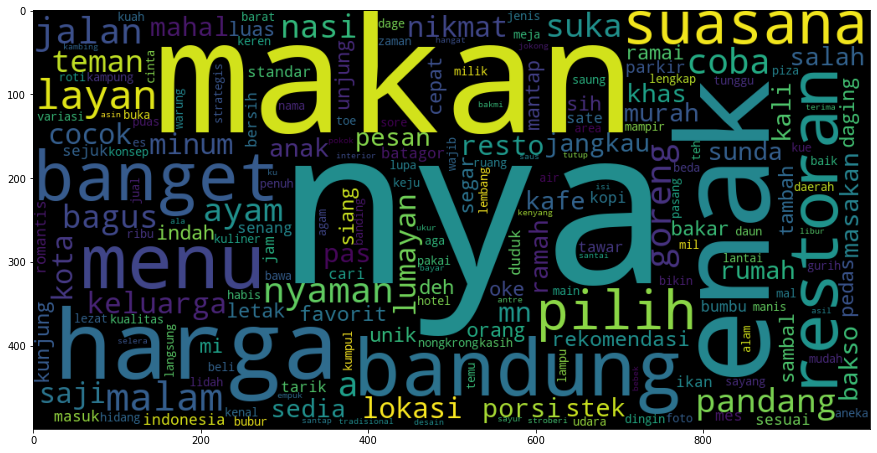

In [24]:
positive_word = []
for text in df_train[df_train['sentiment']=='positive']['text']:
  for word in text.split():
    positive_word.append(word)
x = Counter(positive_word)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

5549


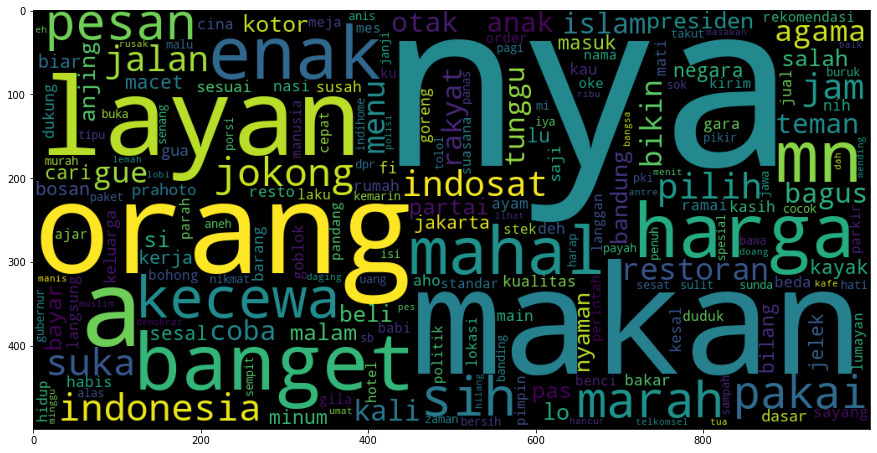

In [25]:
negative_word = []
for text in df_train[df_train['sentiment']=='negative']['text']:
  for word in text.split():
    negative_word.append(word)
x = Counter(negative_word)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

3449


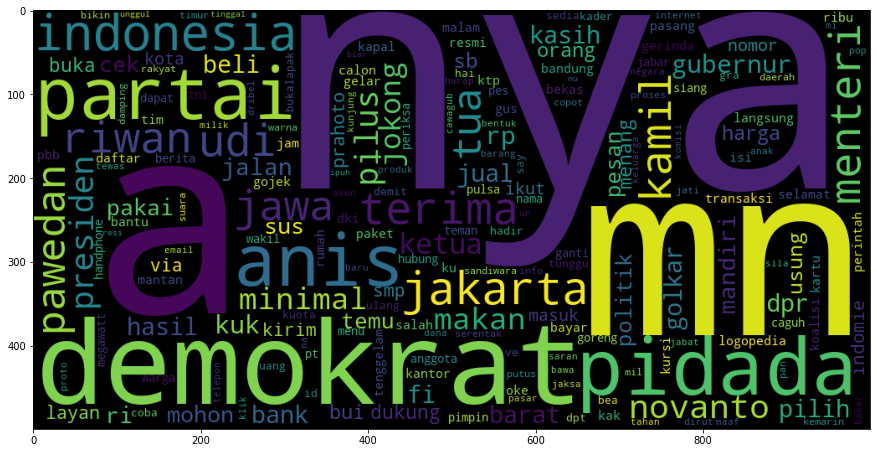

In [26]:
neutral_word = []
for text in df_train[df_train['sentiment']=='neutral']['text']:
  for word in text.split():
    neutral_word.append(word)
x = Counter(neutral_word)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)